In [157]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns
import missingno as msno
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### 결측치 점검

In [158]:
df_raw = pd.read_csv('C:\\Users\\user\\Downloads\\0822_H_data.csv')

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Columns: 254 entries, id to hm_01_rel_t
dtypes: float64(178), int64(74), object(2)
memory usage: 29.0+ MB


In [159]:
df = df_raw.drop(['emp_keep_a', 'hazard_phy_d','hazard_phy_a','hazard_phy_c','hazard_phy_e','hazard_phy_f','hazard_phy_g','hazard_phy_h', 'hazard_phy_i', 'ch_downsizing', 'job_c1_r', 'job_c1', 'emp_pay_type', 'skillmat', 'emp_comp_com_a','emp_comp_com_b','emp_comp_com_c','ch_ic','ch_restruct','wplace_sl','emp_noncon', 'wcomback'], axis = 1)

In [160]:
# 널값 개수와 비율 계산
null_summary = (
    df.isnull().sum()
      .to_frame("널값 개수")
      .assign(널값비율 = lambda x: (x["널값 개수"] / len(df_raw) * 100).round(2))
      .reset_index()
      .rename(columns={'index': '컬럼명'})
)

# 널값 있는 열만 필터링 & 비율 기준 내림차순 정렬
null_summary = (
    null_summary[null_summary["널값 개수"] > 0]
    .sort_values(by="널값비율", ascending=False)
    .reset_index(drop=True)
)

print(null_summary)

                  컬럼명  널값 개수  널값비율
0         comp_size_b    870  5.82
1        wtime_ftwork    584  3.90
2            emp_keep    581  3.88
3          emo_manual    307  2.05
4    wtime_resilience    279  1.87
..                ...    ...   ...
150       wsituation7      2  0.01
151      wsituation13      1  0.01
152            wstat1      1  0.01
153         winten2_a      2  0.01
154     wtime_length3      2  0.01

[155 rows x 3 columns]


In [161]:
# start 파일
# df.to_csv("2PD_v1_0822.csv", encoding="CP949")

### 중복 피쳐 삭제/8,9->결측치 수정

In [162]:
# 불필요한 피쳐 삭제하기 (14개)
df = df.drop(columns=["ptime_r", "stratification", "district", "household", "target", "mode", "hh_num", "eli_num", "hm_01_gender", "hm_01_year", "hm_01_estat", "hm_01_rel_t","wtime_week", "earning1_r"])

print(df)

              id burnout60  area  gender  age  wduration_y  earning1  \
0      1000042_1       lv1     1       1   49           10       500   
1      1000051_1       lv2     1       1   31            2       300   
2      1000056_1       lv1     1       1   32            2       300   
3      1000069_1       lv1     1       1   38            2       390   
4      1000069_2       lv1     1       2   37            5       330   
...          ...       ...   ...     ...  ...          ...       ...   
14951  2010124_1       lv1     7       1   37            6       450   
14952  2010133_1       lv2     7       2   46            3       230   
14953  2010134_2       lv1     7       2   34            5       320   
14954  2010137_1       lv1     7       1   57            5       450   
14955  2010137_2       lv1     7       2   29            3       350   

       earning2_r  wtime_r  woutside4_a  ...  edu  marital  children  \
0               6     40.0            1  ...  5.0      1.0     

In [163]:
# 전처리: 8, 9 NULL (5개)
cols = ["hazard_erg_a", "hazard_erg_b", "hazard_erg_c", "hazard_erg_d", "hazard_erg_e"]

df[cols] = df[cols].replace([8, 9], pd.NA)

print(df['hazard_erg_a'].unique())
print(df['hazard_erg_b'].unique())
print(df['hazard_erg_c'].unique())
print(df['hazard_erg_d'].unique())
print(df['hazard_erg_e'].unique())


[6 2 1 7 5 4 3 <NA>]
[1 5 6 3 4 7 2 <NA>]
[ 7.  6.  2.  5.  4.  3.  1. nan]
[ 7.  2.  5.  4.  6.  3. nan  1.]
[ 7.  3.  5.  6.  4.  2.  1. nan]


In [164]:
# 잘못 변경된 변수명 복원
df.rename(columns={
    "wsituation": "wsituation8",
    "wsituation.1": "wsituation9",
    "disc": "disc9",
    "disc.1": "disc8"
}, inplace=True)

### 긍/부정 변경

In [165]:
df["wstat4"].head(10) 

0    2
1    2
2    2
3    3
4    5
5    5
6    5
7    5
8    5
9    5
Name: wstat4, dtype: int64

In [166]:
# 긍/부정 변경
# 5점 척도

cols = [
    "wstat4", "wstat6",
    "wwa1", "wwa2", "wwa3", "wwa4", "wwa5",
    "sleep1", "sleep2", "sleep3",
    "imte1", "imte2", "imte3", "imte4", "imte5",
    "wsituation12", "wsituation14"
]

# 변환 딕셔너리 (5점 척도 역코딩)
reverse_map = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}

# 여러 열에 적용
for col in cols:
    df[col] = df[col].map(reverse_map).fillna(df[col])

df["wstat4"].head(10) 

0    4
1    4
2    4
3    3
4    1
5    1
6    1
7    1
8    1
9    1
Name: wstat4, dtype: int64

In [167]:
# 3점 척도 
cols_2 = [
   "heal_lim1"
]

# 변환 딕셔너리 (3점 척도 역코딩)
reverse_map = {1: 3, 2: 2, 3: 1}

# 여러 열에 적용
for col in cols_2:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_2].head())
#%%
df["heal_lim1"].head(10) 
#%%


['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: heal_lim1, dtype: float64

In [168]:
# 4점 척도
cols_1 = [
    "imte1", "imte2", "imte3", "imte4", "imte5",
]

# 변환 딕셔너리 (4점 척도 역코딩)
reverse_map = {1: 4, 2: 3, 3: 2, 4: 1}

# 여러 열에 적용
for col in cols_1:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_1].head())
#%%
df["imte1"].head(10) 
#%%

['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    1.0
1    1.0
2    1.0
3    3.0
4    2.0
5    2.0
6    2.0
7    1.0
8    2.0
9    2.0
Name: imte1, dtype: float64

### 연속형 변수 재범주화

In [169]:
df['heal_abs1'].value_counts()

heal_abs1
0.0      14127
2.0        181
1.0        127
3.0        113
5.0         80
7.0         65
10.0        31
8.0         25
4.0         24
6.0         10
15.0         9
20.0         6
30.0         6
14.0         5
13.0         5
12.0         4
90.0         3
60.0         2
11.0         1
180.0        1
120.0        1
50.0         1
21.0         1
Name: count, dtype: int64

In [170]:
# 범주화 

df["heal_abs1_group"] = np.where(df["heal_abs1"] == 0, 0, 1)
df['heal_abs1_group'] = df['heal_abs1_group'].map({0: 1, 1: 2})
#%%
print(df["heal_abs1_group"].head())
#%%
df["heal_abs1_group"].value_counts()


0    1
1    1
2    1
3    1
4    1
Name: heal_abs1_group, dtype: int64


heal_abs1_group
1    14127
2      829
Name: count, dtype: int64

In [171]:
# 구간 (0~60, 61~120, 121 이상)
bins = [0, 60, 120, float("inf")]
labels = [1, 2, 3]

df["ctime_group"] = pd.cut(df["ctime"], bins=bins, labels=labels, right=True)
#%%
print(df["ctime_group"].head())
#%%
df["ctime_group"].value_counts()
#%%

0      1
1      1
2      1
3      2
4    NaN
Name: ctime_group, dtype: category
Categories (3, int64): [1 < 2 < 3]


ctime_group
1    12582
2     1150
3      328
Name: count, dtype: int64

In [172]:
# 파생변수로 대체된 컬럼 삭제
df = df.drop(['heal_abs1','ctime'], axis = 1)
print(df)

              id burnout60  area  gender  age  wduration_y  earning1  \
0      1000042_1       lv1     1       1   49           10       500   
1      1000051_1       lv2     1       1   31            2       300   
2      1000056_1       lv1     1       1   32            2       300   
3      1000069_1       lv1     1       1   38            2       390   
4      1000069_2       lv1     1       2   37            5       330   
...          ...       ...   ...     ...  ...          ...       ...   
14951  2010124_1       lv1     7       1   37            6       450   
14952  2010133_1       lv2     7       2   46            3       230   
14953  2010134_2       lv1     7       2   34            5       320   
14954  2010137_1       lv1     7       1   57            5       450   
14955  2010137_2       lv1     7       2   29            3       350   

       earning2_r  wtime_r  woutside4_a  ...  children  panel_survey  ind  \
0               6     40.0            1  ...       1.0    

### 중복 피쳐 삭제

In [173]:
# 1차 프로젝트에서 파생변수 만들었던 변수 삭제
df = df.drop(['occ', 'occ2', 'age', 'earning2_r', 'wday_week', 'woutside4', 'wtime_r', 'wduration_y'], axis = 1)

### 상관관계 매트릭스 분석

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)
# sns.heatmap(corr, cmap="coolwarm", center=0)
# plt.show()

In [175]:
# 상관계수 절댓값이 0.8 이상인 쌍만 추출 (자기 자신 제외)
high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  
        .stack()                                               
        .reset_index()
        .rename(columns={'level_0': '변수1', 'level_1': '변수2', 0: '상관계수'})
)

# 조건 필터링
high_corr = high_corr[high_corr['상관계수'].abs() >= 0.8]

print(high_corr.sort_values(by='상관계수', ascending=False).head(20))

                    변수1           변수2      상관계수
10060       comp_size_b  comp_sizeb_r  1.000000
10059       comp_size_b  comp_sizea_r  1.000000
15552             disc3         disc4  0.988628
20492               ind          ind2  0.985571
15452             disc2         disc3  0.984493
15453             disc2         disc4  0.982562
1780     compsize_group  comp_sizeb_r  0.975227
1636     compsize_group   comp_size_b  0.969841
15351             disc8         disc2  0.962101
15353             disc8         disc4  0.956305
15352             disc8         disc3  0.954483
15249             disc7         disc8  0.944109
15250             disc7         disc2  0.920967
20499      comp_sizea_r  comp_sizeb_r  0.920086
2165   compsize_group_a  comp_sizeb_r  0.916659
15252             disc7         disc4  0.913893
15251             disc7         disc3  0.913422
1779     compsize_group  comp_sizea_r  0.910546
2021   compsize_group_a   comp_size_b  0.893071
15146             disc6         disc7  0

In [176]:
unique_vars = set(high_corr['변수1']).union(set(high_corr['변수2']))
print("조건 충족하는 변수 개수:", len(unique_vars))
print("변수 목록:", unique_vars)

조건 충족하는 변수 개수: 23
변수 목록: {'disc2', 'comp_sizea_r', 'compsize_group', 'disc6', 'woutside_group', 'ind', 'earning1', 'earning2_group_b', 'winten2_b', 'comp_size_b', 'disc3', 'disc7', 'decla_b', 'decla_a', 'woutside4_a', 'disc8', 'winten3_c', 'disc4', 'winten2_a', 'winten3_d', 'ind2', 'compsize_group_a', 'comp_sizeb_r'}


In [177]:
# 상관분석 결과 필요없는 변수 삭제
df = df.drop(['comp_size_b', 'comp_sizea_r', 'comp_sizeb_r', 'ind', 'ind2', 'earning1', 'woutside4_a'], axis = 1)

In [178]:
# disc 변수 : 차별 유/무로 파생변수 생성
cols = ['disc1','disc2','disc3','disc4','disc5',
        'disc6','disc7','disc8','disc9','disc10','disc11']

# 하나라도 1이 있으면 1, 아니면 0
df['disc_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['disc_group'] = df['disc_group'].map({0: 1, 1: 2})

print(df['disc_group'].unique())

[2 1]


In [179]:
# decla 변수 : 작업선택의 가능성 유/무로 파생변수 생성
cols = ['decla_a','decla_b']

# 하나라도 1이 있으면 1, 아니면 0
df['decla_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['decla_group'] = df['decla_group'].map({0: 1, 1: 2})

print(df['decla_group'].unique())

[2 1]


In [180]:
# winten2 변수 : 작업 강도가 세다로 파생변수 생성(7점 척도)
cols = ['winten2_a','winten2_b']

# 둘 중 하나라도 있으면 최대값
df['winten2_group'] = df[cols].max(axis=1, skipna=True)

print(df['winten2_group'].unique())

[ 5.  6.  7.  1.  4.  3.  2. nan]


In [181]:
# winten3 변수 : 작업선택의 가능성 유/무로 파생변수 생성
cols = ['winten3_c','winten3_d', 'winten3_a', 'winten3_b', 'winten3_e']

# 하나라도 1이 있으면 1, 아니면 0
df['winten3_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['winten3_group'] = df['winten3_group'].map({0: 1, 1: 2})

print(df['winten3_group'].unique())

[2 1]


In [182]:
# 파생변수로 대체된 컬럼 삭제
df = df.drop(['disc1','disc2','disc3','disc4','disc5',
              'disc6','disc7','disc8','disc9','disc10','disc11','decla_a','decla_b','winten2_a','winten2_b', 'winten3_c','winten3_d', 'winten3_a', 'winten3_b', 'winten3_e'], axis = 1)

### 조작적 정의에 사용된 변수 삭제

In [183]:
df = df.drop(['weng1','weng2','weng3','wsituation14','wwa2','sleep2','sleep3','weng4','weng5','wsituation1','wstat4','wsituation2','wsituation12', 'wsituation10','wsituation9'], axis = 1)

### 널값 삭제

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Columns: 172 entries, id to winten3_group
dtypes: category(1), float64(133), int64(34), object(4)
memory usage: 19.5+ MB


In [185]:
df_new = df.dropna()

In [186]:
df_new

,id,burnout60,area,gender,wtime_length5,age_group,emp_period_group,wtime_group,compsize_group,woutside_group,...,edu,marital,children,panel_survey,heal_abs1_group,ctime_group,disc_group,decla_group,winten2_group,winten3_group
0,1000042_1,lv1,1,1,2,4,5,2,4,0,...,5.0,1.0,1.0,2,1,1,2,2,5.0,2
1,1000051_1,lv2,1,1,2,3,2,2,11,0,...,6.0,2.0,2.0,2,1,1,2,2,6.0,2
2,1000056_1,lv1,1,1,2,3,2,2,1,0,...,5.0,2.0,2.0,2,1,1,2,2,5.0,2
3,1000069_1,lv1,1,1,2,3,2,2,10,0,...,6.0,1.0,1.0,2,1,2,2,2,7.0,2
5,1000077_1,lv1,1,1,2,3,2,2,10,0,...,6.0,1.0,2.0,2,1,1,2,2,6.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14949,2009922_1,lv1,13,1,1,3,5,2,12,1,...,6.0,2.0,2.0,2,1,1,2,2,4.0,2
14952,2010133_1,lv2,7,2,2,4,3,2,4,0,...,5.0,2.0,2.0,2,1,1,2,2,4.0,2
14953,2010134_2,lv1,7,2,2,3,4,2,4,0,...,6.0,2.0,2.0,2,1,1,2,2,5.0,2
14954,2010137_1,lv1,7,1,2,5,4,2,4,0,...,6.0,1.0,1.0,2,1,1,2,2,5.0,2


### AutoML

In [187]:
df_new['burnout60'].unique()

array(['lv1', 'lv2', 'lv3'], dtype=object)

In [188]:
# 타겟 클래스번호 전처리
df_new['burnout60'] = df_new['burnout60'].replace("lv1", 1)
df_new['burnout60'] = df_new['burnout60'].replace("lv2", 2)
df_new['burnout60'] = df_new['burnout60'].replace("lv3", 3)
df_new['burnout60'].unique()

array([1, 2, 3], dtype=int64)

In [189]:
df_new['burnout60'] = df_new['burnout60'].astype('category')
print(df_new["burnout60"])

0        1
1        2
2        1
3        1
5        1
        ..
14949    1
14952    2
14953    1
14954    1
14955    1
Name: burnout60, Length: 11243, dtype: category
Categories (3, int64): [1, 2, 3]


In [190]:
# categories.values

In [191]:
categories = df_new.drop(columns=['id', 'burnout60']).columns

In [192]:
categories = categories.tolist()

In [193]:
from pycaret.classification import *
from sklearn.preprocessing import *
# import imblearn
setup_clf = setup(df_new, target = 'burnout60',
                  train_size = 0.8,
                  # ignore_features = ['pclass', 'adult_male', 'deck', 'embark_town', 'alive'],
                  # numeric_features = [],
                  categorical_features = categories,
                  # encoding_method = None,
                #   normalize = True,
                #   normalize_method = 'zscore',
                  # remove_outliers = True,
                #   feature_selection = True,
                  # feature_selection_method = 'classic',
                  # fix_imbalance = True,
                  # fix_imbalance_method = 'SMOTE',
                  fold=5,
                  n_jobs = - 1,
                  session_id = 1234)

,Description,Value
0,Session id,1234
1,Target,burnout60
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2"
4,Original data shape,"(11243, 172)"
5,Transformed data shape,"(11243, 554)"
6,Transformed train set shape,"(8994, 554)"
7,Transformed test set shape,"(2249, 554)"
8,Categorical features,170
9,Preprocess,True


In [194]:
X_train_transformed = get_config('X_train_transformed')
print(X_train_transformed)

              id  area_15.0  area_9.0  area_1.0  area_2.0  area_5.0  \
13039  1263166_1        1.0       0.0       0.0       0.0       0.0   
8216   1146807_1        0.0       1.0       0.0       0.0       0.0   
1529   1025402_2        0.0       0.0       1.0       0.0       0.0   
1971   1034083_1        0.0       0.0       1.0       0.0       0.0   
2748   1046201_1        0.0       0.0       0.0       1.0       0.0   
...          ...        ...       ...       ...       ...       ...   
12863  1254489_1        0.0       0.0       0.0       0.0       0.0   
6917   1125201_1        0.0       0.0       0.0       0.0       0.0   
5985   1103941_1        0.0       0.0       0.0       0.0       1.0   
12451  1243720_1        0.0       0.0       0.0       0.0       0.0   
10791  1192682_1        0.0       0.0       0.0       0.0       0.0   

       area_10.0  area_12.0  area_3.0  area_17.0  ...  disc_group  \
13039        0.0        0.0       0.0        0.0  ...         1.0   
8216     

In [195]:
best = compare_models(fold=10, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8765,0.8756,0.8765,0.8526,0.8551,0.3722,0.4011,1.3060
rf,Random Forest Classifier,0.8618,0.8593,0.8618,0.8082,0.8105,0.1301,0.2104,1.1030
et,Extra Trees Classifier,0.8635,0.8578,0.8635,0.8139,0.8163,0.1642,0.2390,1.0470
knn,K Neighbors Classifier,0.8418,0.6810,0.8418,0.7901,0.8060,0.1281,0.1501,1.2950
dt,Decision Tree Classifier,0.7982,0.6335,0.7982,0.8054,0.8016,0.2258,0.2262,0.9950
dummy,Dummy Classifier,0.8553,0.5000,0.8553,0.7316,0.7887,0.0000,0.0000,0.8980
ada,Ada Boost Classifier,0.8696,0.0000,0.8696,0.8407,0.8469,0.3377,0.3649,1.9950
gbc,Gradient Boosting Classifier,0.8766,0.0000,0.8766,0.8501,0.8532,0.3612,0.3956,2.7600


In [196]:
# !pip install lightgbm

In [197]:
import lightgbm as lgb
print(lgb.__version__)

4.6.0


In [198]:
lgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8777,0.8913,0.8777,0.8523,0.8556,0.3720,0.4045
1,0.8733,0.8789,0.8733,0.8491,0.8522,0.3626,0.3875
2,0.8733,0.8416,0.8733,0.8463,0.8471,0.3246,0.3651
3,0.8766,0.8849,0.8766,0.8529,0.8565,0.3853,0.4103
4,0.8710,0.8739,0.8710,0.8470,0.8525,0.3679,0.3872
Mean,0.8744,0.8741,0.8744,0.8495,0.8528,0.3625,0.3909
Std,0.0025,0.0173,0.0025,0.0027,0.0033,0.0204,0.0158


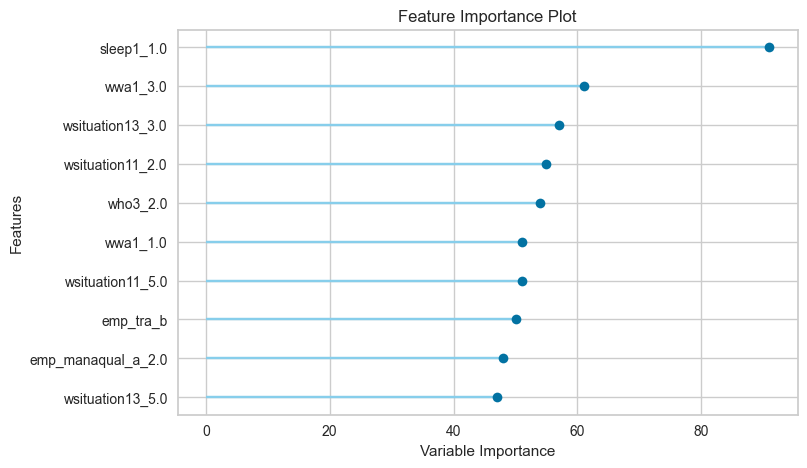

In [199]:
plot_model(lgbm_model, plot='feature')